# A/B test analysis report 
### Author: Xia Cui 


### Introduction

This report presents the analysis of an A/B test. The test was launched on 2020-12-07 and the users were added to the test until 2020-12-21. The entire experiment lasted 23 days and stopped on 2021-01-01. 

The users were split into 2 groups, group A is the control group and group B used the new payment funnel. The goal of the test is to see if users show better converstion rate at each stage of the funnel (`→product_page → product_cart → purchase`) within 14 days of signing up. A total of 6000 participants were expected to be in the test, 15% from EU region.  

In addition to the recommender_system_test, there is another A/B test - interface_eu_test occuring at the same time. While it is possible that this is part of the recommender_system_test for users in the EU region, it is not clearly stated in the task given. Since we were not provided with clear instructions on this test, it will still be analysed briefly but won't be the focus of analysis. 

In what follows, we will first import and preprocess the data to see if the user and event data we were given match the test description. Then an exploratory analysis will be carried out for the recommender_system_test groups to reveal any patterns in users' behaviour. Finally a statistical testing will be performance to see if indeed the two groups have different conversion rates through the sales funnel. 

In addition to the above analysis of the recommender_system_test, a quick analysis of the interface_eu_test will be presented at the very end of the report. 

### Table of content 
#### [Part 1: Data importing](#importing)  
#### [Part 2: Data preprocessing](#preprocessing)  
#### [Part 3: Exploratory data analysis](#eda)  
#### [Part 4: Hypothesis testing](#testing)  
#### [Part 5: Findings and conclusions](#conclusion)  

In [1]:
#import the libraries needed
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
from matplotlib import pyplot as plt
from scipy import stats as st
from IPython.display import display
import seaborn as sns
import warnings
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
%matplotlib inline

### Part 1: Data importing

<a id="importing"></a>

In this section, we will import and check the data.

#### 1.1 Data importing

In [2]:
#import the first 50 rows to check data shape and type
#marketing dataset is expected to be small so all will be imported in one go
marketing = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
df_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events_us.csv', nrows=50)    
df_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users_us.csv', nrows = 50)
df_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants_us.csv', nrows=50)

In [3]:
display(marketing)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


It's a small information dataset so we will keep it as it is. It is worth noticing from above that the there is a promotion event around Christmas and New Year (from 25th of December to 3 or January). This overlaps with the duration of the A/B test. In theory, we will try to avoid times like this to perform the A/B test so as to exclude external influences to user_behaviour as much as possible. However, this is the data we were given, and to some extent we can assume that both A and B groups are likely to be affected by the promotion in similar ways.  

So we will go ahead to perform and A/B test analysis, being aware of the possible impact this marketing event might have on users. 

In [4]:
#check the event data
df_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
user_id       50 non-null object
event_dt      50 non-null object
event_name    50 non-null object
details       50 non-null float64
dtypes: float64(1), object(3)
memory usage: 1.7+ KB


In [6]:
df_events['event_name'].value_counts()

purchase    50
Name: event_name, dtype: int64

Here in the events dataset, event_name needs to be categorical, and event_dt of datetime datatype.

In [7]:
#check the users dataset
df_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [8]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
user_id       50 non-null object
first_date    50 non-null object
region        50 non-null object
device        50 non-null object
dtypes: object(4)
memory usage: 1.7+ KB


In [9]:
df_users['region'].value_counts()

EU           35
N.America     7
APAC          4
CIS           4
Name: region, dtype: int64

In [10]:
df_users['device'].value_counts()

Android    17
PC         16
iPhone     15
Mac         2
Name: device, dtype: int64

Okay. Here the 'region' and 'device' column needs to be of categorical type, and first_date is of datetime datatype. 

In [11]:
#check the participants data
df_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [12]:
df_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
user_id    50 non-null object
group      50 non-null object
ab_test    50 non-null object
dtypes: object(3)
memory usage: 1.3+ KB


In [13]:
df_participants['group'].value_counts()

A    35
B    15
Name: group, dtype: int64

In [14]:
df_participants['ab_test'].value_counts()

recommender_system_test    50
Name: ab_test, dtype: int64

Both should be categorical columns. 

Next, let's import that data using the correct datatypes. 

In [15]:
#import data with correct datatype
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events_us.csv',
                    parse_dates = ['event_dt'],
                    dtype = {'event_name': 'category'})    
users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users_us.csv',
                   parse_dates = ['first_date'],
                   dtype = {'region':'category', 'device':'category'})
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants_us.csv',
                          dtype = {'group': 'category', 'ab_test':'category'})

#### 1.2 Data checking 

Now let's just quickly check the datasets to see how many users are there, the date range of the events and when users are added, as well as missing values and duplicates. 

In [16]:
events.shape

(440317, 4)

In [17]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null datetime64[ns]
event_name    440317 non-null category
details       62740 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1), object(1)
memory usage: 10.5+ MB


In [18]:
#check how many unique users 
events['user_id'].nunique()

58703

In [19]:
print('First event dattime: {}\nLast event datetime: {}'.format(events['event_dt'].min(), events['event_dt'].max()))

First event dattime: 2020-12-07 00:00:33
Last event datetime: 2020-12-30 23:36:33


Event datetime range looks correct. Let's check the users dataset next. 

In [20]:
users.shape

(61733, 4)

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null category
device        61733 non-null category
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 1.1+ MB


In [22]:
#check how many unique users in the users' table
users['user_id'].nunique()

61733

Okay. The number of unique users in both events and users datasets match. Let's next check the date range when the users were added. 

In [23]:
print('Earliest users: ', users['first_date'].min())
print('Newest users: ', users['first_date'].max())

Earliest users:  2020-12-07 00:00:00
Newest users:  2020-12-23 00:00:00


The test stopped taking new users after 21st of December, 2020. So the users added later than that date is not part of the A/B test process. We will need to remove those users from all relevant datasets later. 

Next, let's check the participants dataset. 

In [24]:
participants.shape

(18268, 3)

In [25]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null category
ab_test    18268 non-null category
dtypes: category(2), object(1)
memory usage: 178.6+ KB


In [26]:
#check number of unique users in the participants dataset 
participants['user_id'].nunique()

16666

From the above we can see that there are only 13638 users who took part in the A/B test, as opposed to 58703. For the A/B testing analysis, we will only keep those 13638 users. We will need to remove those who are not among these users from both the users and events data. 

Next, let's check for missing values and duplicates

In [27]:
marketing.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [28]:
marketing.duplicated().sum()

0

In [29]:
#check the proportion of missing values from events dataset
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

All the missing values from the events dataset happens to the column of details. We know this one is for purchase values. So let's take a look at how events are spread.

In [30]:
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Okay. This might explain the missing values. Events other than purchase wouldn't have the details in USD. The number of purchase values and the missing values also add up to exactly the length of the dataset: 423761. But let's check if there are missing values for the purchase events anyway. 

In [31]:
events[events['event_name'] == 'purchase'].isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

Okay. There is no missing values from the purchase events. It's all good. 

In [32]:
#checking for duplicates
events.duplicated().sum()

0

In [33]:
#checking for missing values in users
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [34]:
#checking if there are repeated user_id's
users['user_id'].duplicated().sum()

0

In [35]:
#checking duplicates in the user dataset
users.duplicated().sum()

0

In [36]:
#checking missing values in the participants dataset
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [37]:
#checking duplicates
participants.duplicated().sum()

0

In theory, there shouldn't be any overlapping of users in the A/B test groups. So let's check to see if that's the case. 

In [38]:
participants['user_id'].duplicated().sum()

1602

In [39]:
#checking what the duplicates look like
participants[participants['user_id'].duplicated()]

,user_id,group,ab_test
6702,773ECB64E45DEBAB,A,interface_eu_test
6704,AABA4219186465C9,A,interface_eu_test
6705,2BA8FA8754D1FE50,B,interface_eu_test
6706,FB6F6BC119E1DBD5,B,interface_eu_test
6715,0ABA6D32AE7AFB9B,A,interface_eu_test
...,...,...,...
18227,EF2E4FAF26951358,A,interface_eu_test
18245,2B0CD24EE4291CA0,B,interface_eu_test
18252,CA6F4DAED160E5B1,A,interface_eu_test
18257,C70DF942E542DA69,A,interface_eu_test


In [40]:
#pick one to check
duplicated_id = participants[participants['user_id'].duplicated()]['user_id']
sample = duplicated_id.sample().values[0]
participants.query("user_id == @sample")

,user_id,group,ab_test
3933,CBC0B1A07E5F787F,A,recommender_system_test
16348,CBC0B1A07E5F787F,B,interface_eu_test


In [41]:
participants.groupby('group')['ab_test'].value_counts()

group  ab_test                
A      interface_eu_test          5831
       recommender_system_test    3824
B      interface_eu_test          5736
       recommender_system_test    2877
Name: ab_test, dtype: int64

From the above we can see there seems to be two A/B test groups here. The B group for recommender_system_test is also a lot smaller than the A group, whereas the two groups are spread evenly for the interface_eu_test. 

There are duplicated user_id's in the participants dataset. A closer check reveals that there are users in more than one groups. We will need to remove such users as a next step. 

Morever, one of the A/B test is interface_eu_test, for which only users from EU regions should be included. We will check on that too. 

### Part 1 Summary 

In this section, we've successfully imported and checked the data and found the following key information:

- the events information might be affected by the marketing promotion during the A/B test period 

- there are users in the users dataset who were added after 2020-12-21 and they will be removed

- there two two A/B test, one is interface_eu_test, the other is recommender_system_test 

- for the recommender system test, B group is a lot smaller than A group, which is not ideal. 

- there are participants who are in more than one test groups. They will need to be removed from the dataset, as well as from the events and users dataset. 

- we will also need to check if all users in the interface_eu_test are from EU. 

These will be addressed in the next section. 

### Part 2: Data preprocessing 

<a id="preprocessing"></a>

Our main task in this section is to remove users who were not part of the test from the data, as well as the duplicates in test participant groups. 

let's first find out how many users were added after the cut off date. 

In [42]:
print(users[users['first_date'] > '2020-12-21'].shape[0] / users.shape[0])
users[users['first_date'] > '2020-12-21'].shape[0]

0.08525424003369349


5263

Less than 1% of the users in the users' dataset will need to be excluded. We can do this later once we confirm the users in the A/B tests. 

Next, let's see which users are in the A/B groups for the two tests. 

We know that there shouldn't be any overlapping in users in between the A and B group. In our case, there also shouldn't be any interaction between the two tests. Otherwise it's impossible to tell which experiment caused the impact. Let's check.

In [43]:
#get the list of users for each test group using the participants dataset
interface_A = participants[(participants['group'] ==
                            'A') & (participants['ab_test'] == 'interface_eu_test')]['user_id'].to_list()
interface_B = participants[(participants['group'] ==
                            'B') & (participants['ab_test'] == 'interface_eu_test')]['user_id'].to_list()
recommender_A = participants[(participants['group'] ==
                              'A') & (participants['ab_test'] == 'recommender_system_test')]['user_id'].to_list()
recommender_B = participants[(participants['group'] ==
                              'B') & (participants['ab_test'] == 'recommender_system_test')]['user_id'].to_list()

In [44]:
#check overlapping between each two groups
print('Number of users in both A and B interface_eu_test groups: ',
      len([i for i in interface_A if i in interface_B]))
print('Number of users in both A and B recommender_syste_test groups: ',
      len([i for i in recommender_A if i in recommender_B]))
print('Number of users in both interface_us_test A group and recommender_system_test A group: ',
      len([i for i in interface_A if i in recommender_A]))
print('Number of users in both interface_us_test A group and recommender_system_test B group: ',
      len([i for i in interface_A if i in recommender_B]))
print('Number of users in both interface_us_test B group and recommender_system_test A group: ',
      len([i for i in interface_B if i in recommender_A]))
print('Number of users in both interface_us_test B group and recommender_test_system B group: ',
      len([i for i in interface_B if i in recommender_B]))

Number of users in both A and B interface_eu_test groups:  0
Number of users in both A and B recommender_syste_test groups:  0
Number of users in both interface_us_test A group and recommender_system_test A group:  482
Number of users in both interface_us_test A group and recommender_system_test B group:  337
Number of users in both interface_us_test B group and recommender_system_test A group:  439
Number of users in both interface_us_test B group and recommender_test_system B group:  344


The above add up to exactly the number of duplicated user_id's.

Once a user is in two groups, we wouldn't able to tell which experiment caused the behaviour change. We also actually don't know whether the users are in fact in two groups or it's an error. Therefore we will need to drop those users from the datasets completely. 

Simply dropping duplicates will keep the first of the duplicated user_id, which won't work for our purpose. We will exclude the those user_id's completely. 

In [45]:
#get the duplicated user_id's. 
duplicated_id = participants[participants['user_id'].duplicated()]['user_id']
len(duplicated_id)

1602

In [46]:
#checking how removing duplicated values will affect the shape of the data
participants[~participants['user_id'].isin(
    duplicated_id)].groupby('group')['ab_test'].value_counts()

group  ab_test                
A      interface_eu_test          5012
       recommender_system_test    2903
B      interface_eu_test          4953
       recommender_system_test    2196
Name: ab_test, dtype: int64

If we remove those users, group B for recommender_system_test got even smaller. However, for the accuracy of the analysis, we will go ahead with the removal. 

In [47]:
participants_ = participants[~participants['user_id'].isin(
    duplicated_id)]
participants_.shape[0]

15064

In [48]:
participants_['user_id'].duplicated().sum()

0

Now it's good. No user is in more than two groups. 

Before we finalize who should be in the test and who shouldn't. Let's check if all the participants who are in the interface_eu_test are actually from the EU region. 

In [49]:
users['region'].value_counts()/len(users)

EU           0.749518
N.America    0.148300
CIS          0.051107
APAC         0.051075
Name: region, dtype: float64

Almost 75% of the users are from EU region. Let's get their user_ids and see if the interface_eu_test participants are from those. 

In [50]:
eu_users = users[users['region'] == 'EU']['user_id'].to_list()

In [51]:
#get the users from the interface_eu_test 
interface_users = participants_[participants_['ab_test'] == 'interface_eu_test']['user_id'].to_list()
len(interface_users)

9965

In [52]:
#compare the updated interface_eu_test users against the eu_users 
len([i for i in interface_users if i in eu_users])

9965

Excellent. All users in the interface_eu_test are from EU. 

Next, we will merge the users dataset with participants dataset, keeping only the users in the participants. Then we will remove those who were added after 2020-12-21. 

In [53]:
users_test = participants_.merge(users, on = 'user_id', how = 'left')
print('Number of users in the original dataset: ', len(users))
print('Number of users in the test: ', len(users_test))
users_test.head()

Number of users in the original dataset:  61733
Number of users in the test:  15064


,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
3,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac
4,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone


Next, let's remove the users added after 2020-12-21.

In [54]:
#exclude the users added after 2020-12-21
users_test = users_test[users_test['first_date'] <= '2020-12-21']
print('Number of users in the test: ', len(users_test))

Number of users in the test:  14062


Finally, let's merge the above dataset with the events dataset, only keep the users who have been in the test and were added before 20201-12-21. 

In [55]:
events_ab = users_test.merge(events, on ='user_id', how = 'inner')
print(events_ab.shape)
events_ab.sample(5)

(88720, 9)


,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
42884,AA60EFB0038DA8BA,A,interface_eu_test,2020-12-15,EU,PC,2020-12-15 20:14:23,product_page,NaN
16444,742C0E363D2C9EA7,B,recommender_system_test,2020-12-07,EU,PC,2020-12-24 17:27:48,product_page,NaN
35432,94DA71DA37CDEFD2,A,interface_eu_test,2020-12-17,EU,Android,2020-12-20 07:46:31,login,NaN
50404,EB8DFF24EDC52127,A,interface_eu_test,2020-12-09,EU,PC,2020-12-11 15:20:18,product_page,NaN
71304,6BFBBB2ECBB28625,A,interface_eu_test,2020-12-15,EU,iPhone,2020-12-26 11:27:34,product_cart,NaN


Finally, let's add a date column for later convenience. 

In [56]:
events_ab['event_date'] = pd.to_datetime(events_ab['event_dt'].dt.date)
events_ab.sample(5)

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
87036,DCACAD1A1A487DBE,A,interface_eu_test,2020-12-10,EU,iPhone,2020-12-10 03:57:22,product_page,NaN,2020-12-10
39474,F28F66E0B114AADD,A,interface_eu_test,2020-12-07,EU,Mac,2020-12-11 13:59:11,product_page,NaN,2020-12-11
5015,2C022D871550873C,B,recommender_system_test,2020-12-09,EU,PC,2020-12-13 20:24:44,purchase,4.99,2020-12-13
57250,842487122CEB89D5,B,interface_eu_test,2020-12-17,EU,Android,2020-12-24 06:30:58,product_cart,NaN,2020-12-24
68044,EC3A288056D4FEAA,A,interface_eu_test,2020-12-07,EU,iPhone,2020-12-07 14:31:33,product_cart,NaN,2020-12-07


### Part 2 summary 

In this section, we've removed the users who were in more than one A/B test group, as well as who were added after December 21, 2020. 

We've also removed the events by those users in the events dataset. Now we have a merged dataset containing the A/B test users information and their events information. 

In the next section, let's carry out an exploratory data analysis for both A/B tests. 

### Part 3: Exploratory data analysis 

<a id="eda"></a>

The expected results of the recommender_system_test is that within 14 days of signing up, users will show better conversion into product page views, product card views and purchases. At each of the stage of the funnel product_page → product_card → purchase, there will be at least a 10% increase.

In this section, we we carry out an exploratory data analysis to first examine the recommender_system_test to see how the two groups performed at each each of the funnel process. In particular we will examine the following matters: 

- the distribution of number of events per user in the two groups 

- the ditribution of number of events by days 

- the purchase values by the two groups

- conversion rates at different funnel stages. 


There is no specific instruction as to what the purpose or expected results are for the interface_eu_test. Therefore it will not be the main focus of this section. 

In [57]:
#examine the event_name values
events_ab['event_name'].value_counts()

login           38330
product_page    24970
purchase        12843
product_cart    12577
Name: event_name, dtype: int64

It's interesting to see that there are more purchases then product_cart overall. This indicates that there are different paths to purchase that the users might follow. Later in this section, we will map out the users' journey to see what it's like. 

In [58]:
#devide the two tests, interface_test for later use
recommender_test = events_ab[events_ab['ab_test'] == 'recommender_system_test']
interface_test = events_ab[events_ab['ab_test'] == 'interface_eu_test']

In [59]:
#check the number of unique users in each group
recommender_test.groupby('group')['user_id'].nunique()

group
A    2082
B     706
Name: user_id, dtype: int64

In [60]:
interface_test.groupby('group')['user_id'].nunique()

group
A    4522
B    4439
Name: user_id, dtype: int64

We know this from previoius steps that the recommender_system_test groups are highly unbalanced, whereas interface_eu_test groups are quite equala in size. 

The test took users for two weeks, and then ran for another 9 days before it ends. The goal of the participants is 6000. As far as the recommender_sytem_test is concerned, the numbers are quite short, especially for the B group. The traffic was not split quite right. It will be tricky to compare the results. This issue will need to be brought up to the web department. 

For the interface_eu_test, we have over 4000 users for each group. It's better, although still short from the goal, if this test has the same participants goal as the recommender system test. 

In what follows, we will carry out the analysis of the recommender_system_test A/B test, first the group's overall performance, followed by the accumulated performance. 

#### 3.1 Analysis of events for the recommender_system_test A/B groups - overall performance

In [61]:
#take another look at the first 5 rows
display(recommender_test.head())

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


In [62]:
#take a look at users and groups by region 
recommender_test.groupby('group')['region'].value_counts()

group  region   
A      EU           13742
       N.America      708
       APAC           160
       CIS            127
B      EU            3784
       N.America      130
       CIS             81
       APAC            72
Name: region, dtype: int64

Region wise, the groups seem to be distributed more or less evenly. 

In [63]:
event_group = recommender_test.groupby('group').agg(
    {'event_name': 'count', 'user_id': 'nunique'}).reset_index()
event_group['events_per_user'] = event_group['event_name'] / \
    event_group['user_id']
event_group

,group,event_name,user_id,events_per_user
0,A,14737,2082,7.078290
1,B,4067,706,5.760623


As shown above, overall group A has on average more than 7 events per user, whereas group B has only 5.7 per user. 

Next, let's take a look at number of events by group by days, bearing in mind that the two groups have very different sizes. 

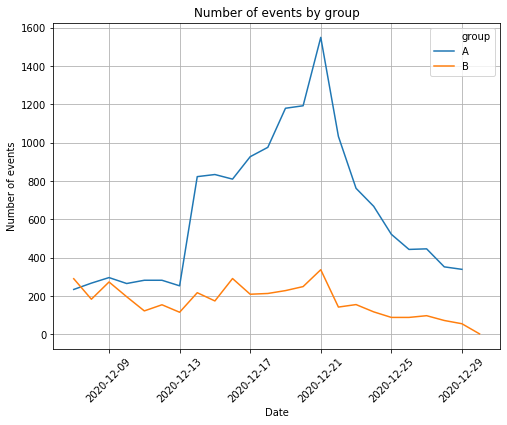

In [64]:
plt.figure(figsize=(8,6))
sns.lineplot(data = recommender_test.groupby(['event_date', 'group']).agg({'event_name' : 'count'}).reset_index(),
             x = 'event_date',
             y= 'event_name',
             hue = 'group')
plt.title('Number of events by group')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.xticks(rotation=45)
plt.show()           

We already know the number of events by group would be different, given the differing size of their users(A: 2082, B: 786). We can notice some similar patterns between the 2 groups: 

- the number of events reached its peak on the 2020-12-21, the day the test stopped taking new users 

- both groups saw a decline in the number of evens after 2020-12-21 

- while group B was fluctuating in number of events between 2020-12-07 and 2020-12-21, group A saw a very obvious jump in the number, following by a drastic drop. 

Next, let's take a look at the two groups' purchase values 

In [65]:
recommender_test[recommender_test['details'].notna()]['details'].describe()

count    2483.000000
mean       22.899787
std        69.447433
min         4.990000
25%         4.990000
50%         4.990000
75%         9.990000
max       499.990000
Name: details, dtype: float64

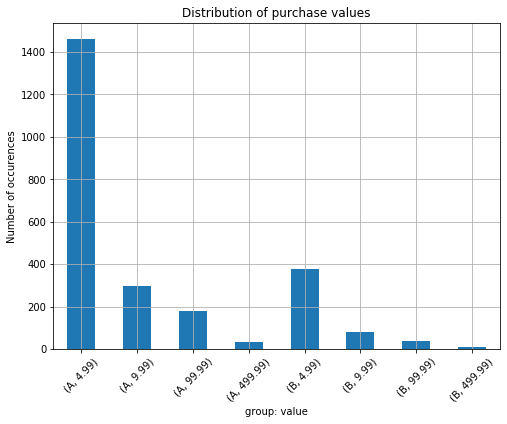

In [66]:
plt.figure(figsize=(8,6))
recommender_test.groupby('group')['details'].value_counts().plot(kind = 'bar')
plt.title('Distribution of purchase values')
plt.grid()
plt.xlabel('group: value')
plt.ylabel('Number of occurences')
plt.xticks(rotation=45)
plt.show()

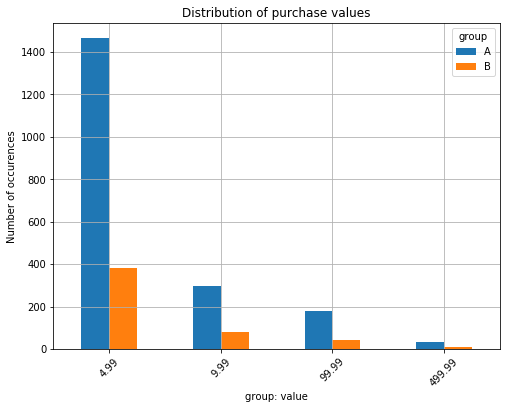

In [67]:
### Reviewer's version

# Or just use pivot_table
recommender_test.groupby('group')['details'].value_counts().unstack().T\
.plot(kind = 'bar', figsize=(8,6))

plt.title('Distribution of purchase values')
plt.grid()
plt.xlabel('group: value')
plt.ylabel('Number of occurences')
plt.xticks(rotation=45)
plt.show()

Now we can see that there are only a total of 4 different values for purchase. Although 499.99 seems a lot larger than the other values, these are not exactly outliers. The purchase values can almost be treated as categorical. 

It also seems that the spread of the purchase values is similar among A/B groups for the recommender_system_test, with 4.99 the highest, followed by 9.99, 99.99, and 499.99. 

Next, let's take a look at the accumulated user behavior change for the two groups.

#### 3.2 Accumulative user behaviour for A/B groups

In [68]:
#for easy manipulation, let's transform the dataset into wide format
recommender_wide = pd.get_dummies(recommender_test, columns = ['event_name'])
recommender_wide = recommender_wide.rename(columns = {'event_name_product_cart' : 'product_cart',
                                                     'event_name_product_page': 'product_page',
                                                     'event_name_purchase': 'purchase',
                                                     'event_name_login': 'login'})
recommender_wide.head(5)

,user_id,group,ab_test,first_date,region,device,event_dt,details,event_date,product_cart,product_page,purchase,login
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,99.99,2020-12-07,0,0,1,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,4.99,2020-12-25,0,0,1,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,NaN,2020-12-07,1,0,0,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,NaN,2020-12-25,1,0,0,0
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,NaN,2020-12-07,0,1,0,0


In [69]:
#change datatype of group for later manipulation
recommender_wide['group'] = recommender_wide['group'].astype('object')

In [70]:
#create the date - group dataset to collect aggregated events data
datesGroups = recommender_test[['event_date', 'group']].drop_duplicates()
eventsAggregated_recommender = datesGroups.apply(
    lambda x: recommender_wide[np.logical_and(recommender_wide['event_date'] <= x['event_date'],
                                              recommender_wide['group'] == x['group'])].agg({
                                                  'user_id': 'nunique',
                                                  'event_date': 'max',
                                                  'group': 'max',
                                                  'login': 'sum',
                                                  'product_page': 'sum',
                                                  'product_cart': 'sum',
                                                  'purchase': 'sum',
                                                  'details': 'sum'}),
    axis=1).sort_values(by=['event_date', 'group'])

We will also add the columns with information of the user conversion at each stage. However, it needs to be noted that this is a simple funnel converstion rate assuming all users follow the login -> product -> cart -> purchase path, which is in fact the case. We will address this in more details in A/B test analysis and user journey. 

In [71]:
eventsAggregated_recommender
eventsAggregated_recommender['login_product'] = eventsAggregated_recommender['product_page'] / \
    eventsAggregated_recommender['login']
eventsAggregated_recommender['page_cart'] = eventsAggregated_recommender['product_cart'] / \
    eventsAggregated_recommender['product_page']
eventsAggregated_recommender['cart_purchase'] = eventsAggregated_recommender['purchase'] / \
    eventsAggregated_recommender['product_cart']

In [72]:
eventsAggregated_recommender.head()

,user_id,event_date,group,login,product_page,product_cart,purchase,details,login_product,page_cart,cart_purchase
0,109,2020-12-07,A,109,70,25,30,744.70,0.642202,0.357143,1.200000
105,129,2020-12-07,B,124,83,36,47,639.53,0.669355,0.433735,1.305556
40,186,2020-12-08,A,230,156,55,60,1479.40,0.678261,0.352564,1.090909
106,165,2020-12-08,B,211,127,62,73,984.27,0.601896,0.488189,1.177419
36,245,2020-12-09,A,365,239,90,103,2803.97,0.654795,0.376569,1.144444


Next let's divide the uesrs into two groups and plot their accumulative change in the number of events. 

In [73]:
cumulative_recommender_A = eventsAggregated_recommender[
    eventsAggregated_recommender['group'] == 'A'].reset_index()
cumulative_recommender_B = eventsAggregated_recommender[
    eventsAggregated_recommender['group'] == 'B'].reset_index()

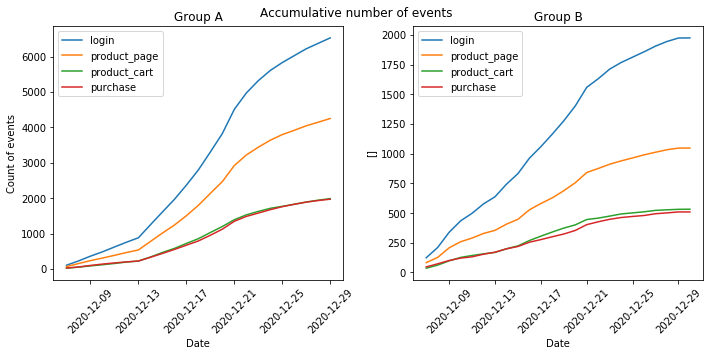

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle('Accumulative number of events')

for event in ['login', 'product_page', 'product_cart', 'purchase']:
    sns.lineplot(data=cumulative_recommender_A, x='event_date',
                 y=event, ax=ax1, label=event)
    sns.lineplot(data=cumulative_recommender_B,
                 x='event_date', y=event, ax=ax2, label=event)

ax1.set_title('Group A')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count of events')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)


ax2.set_title('Group B')
ax2.set_xlabel('Date')
ax2.set_ylabel([])
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
plt.tight_layout()

We can see from the above diagrams that the accumulative change to the number of all four events show a similar pattern between the two groups, although group B showing a slightly slower increase rate. 

Next we will take a look at the accumulative average number of events for both groups. 

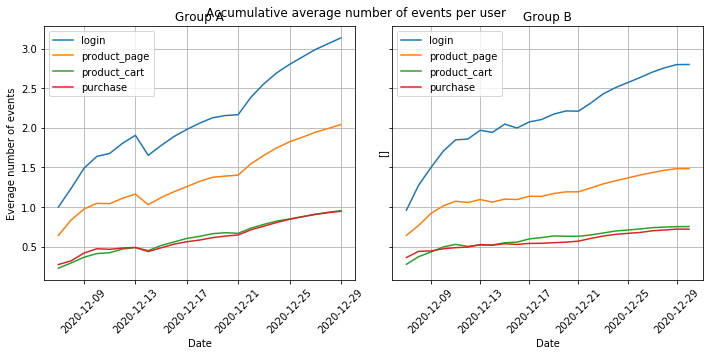

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
plt.suptitle('Accumulative average number of events per user')

for event in ['login', 'product_page', 'product_cart', 'purchase']:
    sns.lineplot(data=cumulative_recommender_A, x='event_date',
                 y=cumulative_recommender_A[event]/cumulative_recommender_A['user_id'], 
                 ax=ax1, 
                 label=event)
    sns.lineplot(data=cumulative_recommender_B,x='event_date', 
                 y=cumulative_recommender_B[event]/cumulative_recommender_B['user_id'], 
                 ax=ax2, 
                 label=event)

ax1.set_title('Group A')
ax1.set_xlabel('Date')
ax1.set_ylabel('Everage number of events')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.grid()

ax2.set_title('Group B')
ax2.set_xlabel('Date')
ax2.set_ylabel([])
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax2.grid()

plt.tight_layout()

From the above, we can see that, as far as the accumulative average number of events per user by events type is concerned, group B overall performaed worse than group A. 

Moreover, the number of accumulative average events still seem to be on the rise at the end of the experiment for both groups.This could be partly due to the Christmas and New Year promotion. 

Finally, let's have a look at the accumulative average purchase per user for the two groups. 

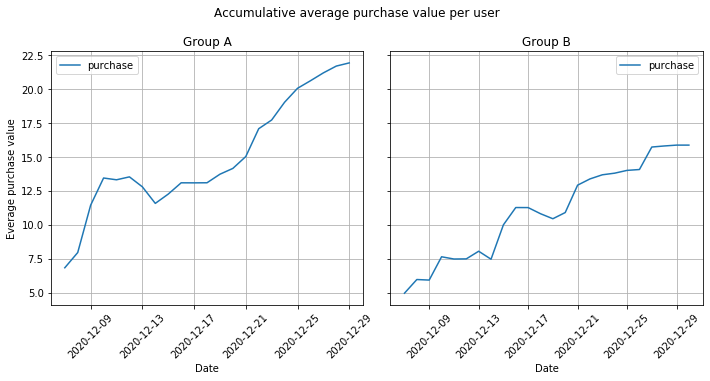

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
plt.suptitle('Accumulative average purchase value per user', y=1.05)

sns.lineplot(data=cumulative_recommender_A, x='event_date',
             y=cumulative_recommender_A['details'] /
             cumulative_recommender_A['user_id'],
             ax=ax1,
             label=event)
sns.lineplot(data=cumulative_recommender_B, x='event_date',
             y=cumulative_recommender_B['details'] /
             cumulative_recommender_B['user_id'],
             ax=ax2,
             label=event)

ax1.set_title('Group A')
ax1.set_xlabel('Date')
ax1.set_ylabel('Everage purchase value')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.grid()

ax2.set_title('Group B')
ax2.set_xlabel('Date')
ax2.set_ylabel('')
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax2.grid()

plt.tight_layout()

Average purchase value wise, we have a similar results here. Group B was performing worse than group A throughout the entire experiment period. Moreover, the number is still on the rise at the end of the experiement, probably because of the Christmas and New Year promotion. 

Having made the above observations about the two groups, we need to be reminded that the two groups are of vastly different sizes. This is not an ideal A/B test situation to start with. Moreover, the user behaviour seems to be affected by the marketing promotion event at the time of the experiment, which is again not ideal for the A/B test. 

Still the conclusions might be valueable to reevaluate the impact of the new recommender system. It certainly doesn't seem to improve the user activity. 

#### 3.3 User journey 

In this section, we will map out the user journey to take a look at how users progress through the different stages. The reference for the functions used can be found here: https://medium.com/multiplyai/user-journey-sankey-diagram-25bb1aa42484. 

Here we will just use the A group as an example to show what kind of path users follow. The conversion rates for both groups will be the focus in next section. 

In [77]:
#divide the two groups
recommender_A = recommender_test[recommender_test['group']=='A']
recommender_B = recommender_test[recommender_test['group']=='B']
recommender_A.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


In [78]:
#define the functions needed to calculate and visualise the user journey
def filter_starting_step(x, starting_step, n_steps):
    """
    Function used to return the first n_steps for each user starting from the "starting_step".
    The function will be used to generate the event sequence journey for each user.
    """
    starting_step_index = x.index(starting_step)
    
    return x[starting_step_index: starting_step_index + n_steps] 

def user_journey(events, starting_step, n_steps=3, events_per_step=5):
    """
    Function used to map out the journey for each user starting from the defined "starting_step" and count
    how many identical journeys exist across users.
    """
    # sort events by time
    events = events.sort_values(['user_id', 'event_dt'])
    # find the users that have performed the starting_step
    valid_ids = events[events['event_name'] == starting_step]['user_id'].unique()

    # plan out the journey per user, with each step in a separate column
    flow = events[(events['user_id'].isin(valid_ids))] \
        .groupby('user_id') \
        .event_name.agg(list) \
        .to_frame()['event_name'] \
        .apply(lambda x: filter_starting_step(x, starting_step=starting_step, n_steps=n_steps)) \
        .to_frame() \
        ['event_name'].apply(pd.Series)

    # fill NaNs with "End" to denote no further step by user; this will be filtered out later
    flow = flow.fillna('End')

    # add the step number as prefix to each step
    for i, col in enumerate(flow.columns):
        flow[col] = '{}: '.format(i + 1) + flow[col].astype(str)

    # replace events not in the top "events_per_step" most frequent list with the name "Other"
    # this is done to avoid having too many nodes in the sankey diagram
    for col in flow.columns:
        all_events = flow[col].value_counts().index.tolist()
        all_events = [e for e in all_events if e != (str(col + 1) + ': End')]
        top_events = all_events[:events_per_step]
        to_replace = list(set(all_events) - set(top_events))
        flow[col].replace(to_replace, [str(col + 1) + ': Other'] * len(to_replace), inplace=True)

    # count the number of identical journeys up the max step defined
    flow = flow.groupby(list(range(n_steps))) \
        .size() \
        .to_frame() \
        .rename({0: 'count'}, axis=1) \
        .reset_index()

    return flow

def sankey_df(events, starting_step, n_steps=3, events_per_step=5):
    """
    Function used to generate the dataframe needed to be passed to the sankey generation function.
    "source" and "target" column pairs denote links that will be shown in the sankey diagram.
    """
    # generate the user user flow dataframe
    flow = user_journey(events, starting_step, n_steps, events_per_step)

    # create the nodes labels list
    label_list = []
    cat_cols = flow.columns[:-1].values.tolist()
    for cat_col in cat_cols:
        label_list_temp = list(set(flow[cat_col].values))
        label_list = label_list + label_list_temp

    # create a list of colours for the nodes
    # assign 'blue' to any node and 'grey' to "Other" nodes
    colors_list = ['blue' if i.find('Other') < 0 else 'grey' for i in label_list]

    # transform flow df into a source-target pair
    for i in range(len(cat_cols) - 1):
        if i == 0:
            source_target_df = flow[[cat_cols[i], cat_cols[i + 1], 'count']]
            source_target_df.columns = ['source', 'target', 'count']
        else:
            temp_df = flow[[cat_cols[i], cat_cols[i + 1], 'count']]
            temp_df.columns = ['source', 'target', 'count']
            source_target_df = pd.concat([source_target_df, temp_df])
        source_target_df = source_target_df.groupby(['source', 'target']).agg({'count': 'sum'}).reset_index()

    # add index for source-target pair
    source_target_df['source_id'] = source_target_df['source'].apply(lambda x: label_list.index(x))
    source_target_df['target_id'] = source_target_df['target'].apply(lambda x: label_list.index(x))

    # filter out the end step
    source_target_df = source_target_df[(~source_target_df['source'].str.contains('End')) &
                                        (~source_target_df['target'].str.contains('End'))]

    return label_list, colors_list, source_target_df

In [79]:
#run the function on A group
label_list, colors_list, source_target_df = sankey_df(
    recommender_A, 'login', 5, 5)

In [80]:
# creating the sankey diagram
data = go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        color=colors_list,
        line=dict(
            color="black",
            width=0.5
        ),
        label=label_list
    ),
    link=dict(
        source=source_target_df['source_id'].values.tolist(),
        target=source_target_df['target_id'].values.tolist(),
        value=source_target_df['count'].astype(int).values.tolist(),
        hoverlabel=dict(
            bgcolor='#C2C4C7')
    )
    )

# set window width so that steps are evenly spaced out
n_steps = 13
if n_steps < 5:
    width = None
else:
    width = n_steps * 250

layout = dict(
    height=400,
    width=width,
    margin=dict(t=30, l=0, r=0, b=30),
    title='diagram',
    font=dict(
        size=10
    )
)

fig = go.Figure(data=[data], layout=layout)
fig.show()

From the above examples that we can see that users clearly follow very different paths to purchases. For example, while most users went from login to product_page, 301 users went straight from login to purchase, and there are even users went back to login again. 

Therefore, the users towards product_page, then to product_cart, and then to purchase funnel is not representative of the user behaviour. It's worth keeping that in mind when we calcualte the funnel conversion rates in the next section. 

#### 3.4 User conversion funnels for A/B groups

In this section, we will take a look at two funnels. First, given all users start from the login page, we will calculate and visualize the user conversion in the funnel: login -> product_page -> product_cart -> purchase. 

However, since we see from previous section, the funnel above is not really representative of user journey. Therefore we will also calculate the simple funnel considering the number of unique users arriving at each of the stage disregarding the sequence. 

In [81]:
#take a look at the data again
recommender_A.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


**Sequence funnel**

In [82]:
#create a pivot table to find the earliest datetime for each event for each user
users_A = recommender_A.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_dt',
    aggfunc='min') 

#create the steps to filter the data
step_1 = ~users_A['login'].isna()
step_2 = step_1 & (users_A['product_page'] >=users_A['login'])
step_3 = step_2 & (users_A['product_cart'] >= users_A['product_page'])
step_4 = step_3 & (users_A['purchase'] >= users_A['product_cart'])

#calculate the users at each stage of the funnel
n_login_A = users_A[step_1].shape[0]
n_product_A = users_A[step_2].shape[0]
n_cart_A = users_A[step_3].shape[0]
n_purchase_A = users_A[step_4].shape[0]

print('login:', n_login_A)
print('product_page:', n_product_A)
print('product_cart:', n_cart_A)
print('purchase:', n_purchase_A) 

login: 2082
product_page: 1360
product_cart: 304
purchase: 36


In [83]:
#visualize the funnel
fig_A = go.Figure(go.Funnel(
    y=["login", "product_page", "product_cart", "purchase"],
    x=[n_login_A, n_product_A,  n_cart_A, n_purchase_A],
    textposition="inside",
    textinfo="value+percent initial"
))

fig_A.update_layout(title={
    'text': "Sales funnel for group A",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

fig_A.show()

From the above we can see, among the total users in the group (2082), 65% went to product_page, then 15% went to product_cart, and finally 1.7% of the initial users went to purchase. 

Next, let's take a look at group B. 

In [84]:
#checking the login to purchase funnel for group A
users_B = recommender_B.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_dt',
    aggfunc='min') 

step_1 = ~users_B['login'].isna()
step_2 = step_1 & (users_B['product_page'] >= users_B['login'])
step_3 = step_2 & (users_B['product_cart'] >= users_B['product_page'])
step_4 = step_3 & (users_B['purchase'] >= users_B['product_cart'])

n_login_B = users_B[step_1].shape[0]
n_product_B = users_B[step_2].shape[0]
n_cart_B = users_B[step_3].shape[0]
n_purchase_B = users_B[step_4].shape[0]

print('login:', n_login_B)
print('product_page:', n_product_B)
print('product_cart:', n_cart_B)
print('purchase:', n_purchase_B) 

login: 706
product_page: 397
product_cart: 83
purchase: 9


In [85]:
fig_B = go.Figure(go.Funnel(
    y=["login", "product_page", "product_cart", "purchase"],
    x=[n_login_B, n_product_B,  n_cart_B, n_purchase_B],
    textposition="inside",
    textinfo="value+percent initial"
))

fig_B.update_layout(title={
    'text': "Sales funnel for group B",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

fig_B.show()

From the above we can see that among the 706 initial users, 56% went to product_page, 12% went to product_cart, and finally, 1.3% went to purchase. 

A statistical testing will be carried out in the next section to see if the conversion rates are statistically different between the two groups. 

**Simple funnel**

Let's first calculate the unique users arriving at each stage for group A.

In [86]:
#get the unique users arriving at each stage for group A
users_login_A = recommender_A.query('event_name =="login"')['user_id'].nunique()
users_product_A = recommender_A.query('event_name =="product_page"')['user_id'].nunique()
users_cart_A = recommender_A.query('event_name =="product_cart"')['user_id'].nunique()
users_purchase_A = recommender_A.query('event_name =="purchase"')['user_id'].nunique()

#print the number
print('login:', users_login_A)
print('product_page:', users_product_A)
print('product_cart:', users_cart_A)
print('purchase:', users_purchase_A) 

#visualize the funnel
fig_A_2 = go.Figure(go.Funnel(
    y=["login", "product_page", "product_cart", "purchase"],
    x=[users_login_A, users_product_A,  users_cart_A, users_purchase_A],
    textposition="inside",
    textinfo="value+percent initial"
))

fig_A_2.update_layout(title={
    'text': "Simple Sales funnel for group A",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

fig_A_2.show()

login: 2082
product_page: 1360
product_cart: 631
purchase: 652


In the funnel above, we notice a slightly higher conversion rate into purchase than into product_cart. This is because, as we previously noted, users don't necessarily go to purchase from product_cart. 

Next, let's take a look at group B. 

In [87]:
#get the unique users arriving at each stage for group B
users_login_B = recommender_B.query('event_name =="login"')['user_id'].nunique()
users_product_B = recommender_B.query('event_name =="product_page"')['user_id'].nunique()
users_cart_B = recommender_B.query('event_name =="product_cart"')['user_id'].nunique()
users_purchase_B = recommender_B.query('event_name =="purchase"')['user_id'].nunique()

#print the number
print('login:', users_login_B)
print('product_page:', users_product_B)
print('product_cart:', users_cart_B)
print('purchase:', users_purchase_B) 

#visualize the funnel
fig_B_2 = go.Figure(go.Funnel(
    y=["login", "product_page", "product_cart", "purchase"],
    x=[users_login_B, users_product_B,  users_cart_B, users_purchase_B],
    textposition="inside",
    textinfo="value+percent initial"
))

fig_B_2.update_layout(title={
    'text': "Simple Sales funnel for group B",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

fig_B_2.show()

login: 706
product_page: 397
product_cart: 195
purchase: 198


From the above we see that group B shows a slightly lower conversion rate into each stage than group B. The difference is especially obvious from login into product_page (65% v.s. 56%)! 

### Part 3 summary 

In this section, we took a closer look at how the two groups performed during the experiment period. 

Admitting the fact that group B is a lot smaller than group A, group B performed worse than group A in all measured aspects, including overall average number of events per user, accumulative average number of events per user, average purchase per user and accumulative average purchase per user. 

The key considerations when interpreting the above outcome includes: 

- the user behaviour for both groups doesn't seem to stablize yet

- user behaviour seems to be affected by the marketing promotion occuring at the time

- group B is a lot smaller than group A. 


We've also examined the the user journey using group A as an example and noticed that there are various paths for users to get to purchase, and the funnel under examination is just one of those. 

In the next section, we will carry out a statistical testing to see if the conversion rates between the two groups are different at eaach stage of the funnel. 

### Part 4: Hypothesis testing

<a id="testing"></a>

#### 4.1 A/B test analysis for recommender_system_test 

In what follows, we will first define a function that take alpha, and the two arrays containing the number of successes and the number of trials respectively. 

The null hypothesis is that there is no difference in the convertion rate at the specified stage between the A and B groups, and the alternative hypothesis is there is a difference between their convertion rates. The test is therefore a 2 sided test, for which the p-value will be adjusted accordingly. 

Given the same data will be used 3 times in the test, login to page_product convertion, page_product to page_cart convertion, and page_cart to purchase convertion, we will use the bonferoni method to adjust the alpha as 0.05 divided by 3. 

In [88]:
#define a function for the test
def test(alpha, successes, trials):
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the the conversion rates")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the conversion rates different") 

#### 4.2 Convertion rate from login to product_page

In [89]:
alpha = .05/3 # significance level

successes = np.array([n_product_A, n_product_B])
trials = np.array([n_login_A, n_login_B])

test(alpha, successes, trials)

p-value:  1.5371909704686715e-05
Rejecting the null hypothesis: there is a significant difference between the the conversion rates


The testing result shows that A and B group do have different conversion rates from into the product_page stage. 

#### 4.3 Convertion rate from product_page to product_cart

In [90]:
alpha = .05/3 # significance level

successes = np.array([n_cart_A, n_cart_B])
trials = np.array([n_product_A, n_product_B])

test(alpha, successes, trials)

p-value:  0.540729987944925
Failed to reject the null hypothesis: there is no reason to consider the conversion rates different


The test result does not give us enough evidence to claim the conversion rate from product_page to product_cart is different between the two groups. 

#### 4.4 Convertion rate from product_cart to purchases

In [91]:
alpha = .05/3 # significance level

successes = np.array([n_purchase_A, n_purchase_B])
trials = np.array([n_cart_A, n_cart_B])

test(alpha, successes, trials)

p-value:  0.8013725424412119
Failed to reject the null hypothesis: there is no reason to consider the conversion rates different


Similar to the above, the test result does not give us enough evidence to claim the conversion rate from product_cart to purchase is different between the two groups. 

### Part 4 summary 

In this section, we carried out the significance testing to test if the conversion rates at eatch stage of the funnel is different for A/B groups in the recommender_system_test. 

While the results show that the conversion rate from login to product_page is different between the two groups, we do not have the evidence to say that is true for the next two stages of the funnel. 

Overall, we can not conclude that users show better conversion rates in the product_page -> product_cart -> purchases in B group than A group. 

### Part 5: Findings and conclusions 

<a id="conclusion"></a>

In conclusion, this report has presented the analysis of an A/B test for the introduction of a new recommender sytem, which ran for 23 days and overlapped with the Christmas and New Year promotion event.

The test itself has some flaws. For one thing, it has has an very uneven users traffic split and group A more than doubled the size of group B. For another, there were users that show up in more than one groups, which we removed for accuracy of analysis. There is also the impact from the marketing promotion to consider when interpreting the results. 

Overall, the analysis of user behaviours shows that those from group B generated less events and purchase values by user both overall and accumulatively than group A. The statistical testing shows except for the conversion rate from login to product_page, the two groups do not show any statistically significant difference in others stages of the funnel. 

It is also worth pointing out that the users are shown to have various path to purchase in the data, and the examined funnel is just one of those. 

Finally, as far as what we can tell from the data, the new recommender system does not seem to work to improve the conversion rates in the specified funnel. There are also technical problems in splitting users that need to be brought to the attention of the web team for future A/B testings. 

### Additional funnels and testing 

In [92]:
interface_test.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
18804,6BCB0F33D3BAB8C2,A,interface_eu_test,2020-12-21,EU,PC,2020-12-21 21:07:21,product_page,NaN,2020-12-21
18805,6BCB0F33D3BAB8C2,A,interface_eu_test,2020-12-21,EU,PC,2020-12-28 00:32:15,product_page,NaN,2020-12-28
18806,6BCB0F33D3BAB8C2,A,interface_eu_test,2020-12-21,EU,PC,2020-12-21 21:07:18,login,NaN,2020-12-21
18807,6BCB0F33D3BAB8C2,A,interface_eu_test,2020-12-21,EU,PC,2020-12-28 00:32:13,login,NaN,2020-12-28
18808,4BA448BCE1343C6F,A,interface_eu_test,2020-12-13,EU,Android,2020-12-13 22:03:01,product_page,NaN,2020-12-13


In [93]:
#devide the A/B groups for the interface_eu_test
interface_A = interface_test[interface_test['group'] == 'A']
interface_B = interface_test[interface_test['group'] == 'B']

Let's first take a look at both the sequence and simple funnels for the two groups

**Sequence funnel for interface_eu_test groups**

In [94]:
#calculating the users at each stage of the funnel for group A
users_A = interface_A.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_dt',
    aggfunc='min') 

step_1 = ~users_A['login'].isna()
step_2 = step_1 & (users_A['product_page'] >= users_A['login'])
step_3 = step_2 & (users_A['product_cart'] >= users_A['product_page'])
step_4 = step_3 & (users_A['purchase'] >= users_A['product_cart'])

n_login_A = users_A[step_1].shape[0]
n_product_A = users_A[step_2].shape[0]
n_cart_A = users_A[step_3].shape[0]
n_purchase_A = users_A[step_4].shape[0]

print('login:', n_login_A)
print('product_page:', n_product_A)
print('product_cart:', n_cart_A)
print('purchase:', n_purchase_A) 

#visualize the funnel
fig_A_interface = go.Figure(go.Funnel(
    y=["login", "product_page", "product_cart", "purchase"],
    x=[n_login_A, n_product_A,  n_cart_A, n_purchase_A],
    textposition="inside",
    textinfo="value+percent initial"
))

fig_A_interface.update_layout(title={
    'text': "Simple Sales funnel for group A",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

fig_A_interface.show()

login: 4521
product_page: 3031
product_cart: 704
purchase: 97


In [95]:
#calculating the users at each stage of the funnel for group B
users_B = interface_B.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_dt',
    aggfunc='min') 

step_1 = ~users_B['login'].isna()
step_2 = step_1 & (users_B['product_page'] >= users_B['login'])
step_3 = step_2 & (users_B['product_cart'] >= users_B['product_page'])
step_4 = step_3 & (users_B['purchase'] >= users_B['product_cart'])

n_login_B = users_B[step_1].shape[0]
n_product_B = users_B[step_2].shape[0]
n_cart_B = users_B[step_3].shape[0]
n_purchase_B = users_B[step_4].shape[0]

print('login:', n_login_B)
print('product_page:', n_product_B)
print('product_cart:', n_cart_B)
print('purchase:', n_purchase_B) 

fig_B_interface = go.Figure(go.Funnel(
    y=["login", "product_page", "product_cart", "purchase"],
    x=[n_login_B, n_product_B,  n_cart_B, n_purchase_B],
    textposition="inside",
    textinfo="value+percent initial"
))

fig_B_interface.update_layout(title={
    'text': "Sales funnel for group B",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

fig_B_interface.show()

login: 4439
product_page: 2914
product_cart: 713
purchase: 85


**Simple funnel for the interface_eu_test**

In [96]:
#get the unique users arriving at each stage for group A
users_login_A = interface_A.query('event_name =="login"')['user_id'].nunique()
users_product_A = interface_A.query('event_name =="product_page"')['user_id'].nunique()
users_cart_A = interface_A.query('event_name =="product_cart"')['user_id'].nunique()
users_purchase_A = interface_A.query('event_name =="purchase"')['user_id'].nunique()

#print the number
print('login:', users_login_A)
print('product_page:', users_product_A)
print('product_cart:', users_cart_A)
print('purchase:', users_purchase_A) 

#visualize the funnel
fig_A_interface_2 = go.Figure(go.Funnel(
    y=["login", "product_page", "product_cart", "purchase"],
    x=[users_login_A, users_product_A,  users_cart_A, users_purchase_A],
    textposition="inside",
    textinfo="value+percent initial"
))

fig_A_2.update_layout(title={
    'text': "Simple Sales funnel for interface_edu_test group A",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

fig_A_interface_2.show()

login: 4521
product_page: 3031
product_cart: 1479
purchase: 1612


In [97]:
#get the unique users arriving at each stage for group A
users_login_B = interface_B.query('event_name =="login"')['user_id'].nunique()
users_product_B = interface_B.query('event_name =="product_page"')['user_id'].nunique()
users_cart_B = interface_B.query('event_name =="product_cart"')['user_id'].nunique()
users_purchase_B = interface_B.query('event_name =="purchase"')['user_id'].nunique()

#print the number
print('login:', users_login_B)
print('product_page:', users_product_B)
print('product_cart:', users_cart_B)
print('purchase:', users_purchase_B) 

#visualize the funnel
fig_B_interface_2 = go.Figure(go.Funnel(
    y=["login", "product_page", "product_cart", "purchase"],
    x=[users_login_B, users_product_B,  users_cart_B, users_purchase_B],
    textposition="inside",
    textinfo="value+percent initial"
))

fig_B_2.update_layout(title={
    'text': "Simple Sales funnel for interface_edu_test group B",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

fig_B_interface_2.show()

login: 4439
product_page: 2914
product_cart: 1516
purchase: 1479


From the above we can already see that the two groups show very little difference in both funnels. However, let's quickly carry out a statisfical testing anyway. 

In [98]:
#significance test for conversion rate from login to product_page
alpha = .05/3 # significance level

successes = np.array([n_product_A, n_product_B])
trials = np.array([n_login_A, n_login_B])

test(alpha, successes, trials)

p-value:  0.1616602694116911
Failed to reject the null hypothesis: there is no reason to consider the conversion rates different


In [99]:
#from product_page to product_cart
alpha = .05/3 # significance level

successes = np.array([n_cart_A, n_cart_B])
trials = np.array([n_product_A, n_product_B])

test(alpha, successes, trials)

p-value:  0.2614187692672718
Failed to reject the null hypothesis: there is no reason to consider the conversion rates different


In [100]:
#from product_cart to purchase
alpha = .05/3 # significance level

successes = np.array([n_purchase_A, n_purchase_B])
trials = np.array([n_cart_A, n_cart_B])

test(alpha, successes, trials)

p-value:  0.2962110555172548
Failed to reject the null hypothesis: there is no reason to consider the conversion rates different


In this section, we carried out a significance test for the interface_eu_test. Given it's not clear the goal of the test, we assume that it has the same goal as the recommender_system_test, which is to see increase in converstion rate in the sales funnel. 

The two groups for the test are quite balanced (4521 vs. 4439). The sales funnels for the two groups show them having only slight difference in conversion rates into the next stage. The significance testing following that further confirmed our observation. 

Therefore we can conclude that, for the period of time that this particular A/B test was carried out, we can not claim that the two groups performed any different as far as conversion rate is concerned. 
